In [28]:
# %pip install catboost

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/Preprocessed_Bank_Customer_Churn_Prediction.csv')

# 사용할 피처 선택 (customer_id 제거)
features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']

X = df[features]
y = df['churn']

In [30]:
from sklearn.metrics import roc_curve, auc

def auc_plot(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [31]:
# 'balance'와 'estimated_salary' 컬럼을 skewed_columns 리스트에 추가
skewed_columns = ['age', 'balance', 'estimated_salary', 'credit_score']  # 'balance'와 'estimated_salary' 추가
# skewed_columns = ['balance', 'estimated_salary', 'credit_score']  # 'balance'와 'estimated_salary' 추가
# skewed_columns = ['age', 'balance', 'estimated_salary']  # 'balance'와 'estimated_salary' 추가

# log1p 변환 함수
def log1p_transform_columns(df, columns):
    for column in columns:
        df[column] = np.log1p(df[column])  # np.log1p는 log(x+1)
    return df

# log1p 변환 수행
df = log1p_transform_columns(df, skewed_columns)

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,6.429719,0,1,42,2,0.000000,1,1,1,11.526334,1
1,6.411818,2,1,41,1,11.336294,1,0,1,11.631096,0
2,6.220590,0,1,42,8,11.980813,3,1,0,11.643362,1
3,6.551080,0,1,39,1,0.000000,2,0,0,11.449215,0
4,6.746412,2,1,43,2,11.740155,1,1,1,11.278280,0


              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1607
           1       0.65      0.45      0.53       393

    accuracy                           0.84      2000
   macro avg       0.76      0.69      0.72      2000
weighted avg       0.83      0.84      0.83      2000



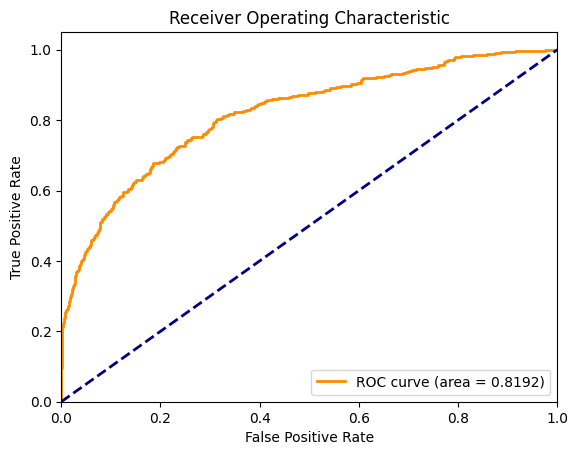

In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성
xgb = XGBClassifier(random_state=42)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))
auc_plot(xgb, X_test, y_test)

In [43]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 생성
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1]
}

# GridSearchCV 수행

grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, n_jobs=-1)

grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력

print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150}


              precision    recall  f1-score   support

           0     0.8705    0.9664    0.9160      1607
           1     0.7500    0.4122    0.5320       393

    accuracy                         0.8575      2000
   macro avg     0.8103    0.6893    0.7240      2000
weighted avg     0.8468    0.8575    0.8405      2000



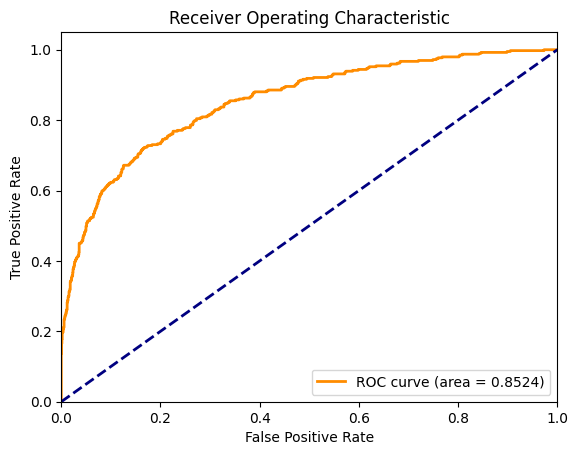

In [41]:
xgb = XGBClassifier(random_state=42, **grid_search.best_params_)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(xgb, X_test, y_test)

Text(0.5, 0, 'Importance')

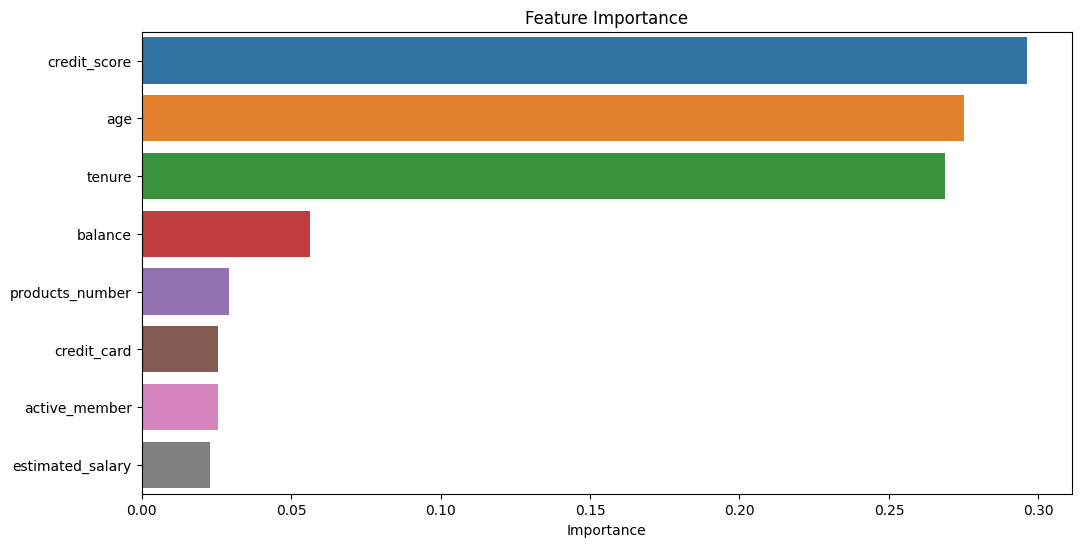

In [42]:
# 피처 중요도 시각화
feature_importance = np.sort(xgb.feature_importances_)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=features, hue=features)

plt.title('Feature Importance')
plt.xlabel('Importance')

In [35]:
# Change sklearn/base.py file ClassifierMixin class to change __sklearn_tags__ method

# def __sklearn_tags__(self):
#     # tags = super().__sklearn_tags__()
#     tags = Tags(estimator_type="classifier", target_tags=TargetTags(required=True))
#     tags.estimator_type = "classifier"
#     tags.classifier_tags = ClassifierTags()
#     tags.target_tags.required = True
#     return tags